# 导入库

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') # 展示高清图，在 Jupyter Notebook 中设置 matplotlib 图形的输出格式为 SVG 格式

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# 读取数据+预处理+PCA降维+划分数据集

In [64]:
data = pd.read_csv(r"F:\Code_Data\Rocks_Spectrum_Reflectance(30).csv",encoding='GBK') #encoding='GBK',防止中文乱码

In [65]:
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]
X_mms = MinMaxScaler().fit_transform(X)
Label = LabelEncoder().fit_transform(y)
data.iloc[:,1:-1] = X_mms
data.iloc[:, -1] = Label
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]

In [66]:
X_dr = PCA(30).fit_transform(X)

In [67]:
# 转换为 torch 中的张量格式
X_tensor = torch.tensor(X_dr, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [68]:
X_tensor.shape, y_tensor.shape

(torch.Size([11548, 30]), torch.Size([11548]))

In [97]:
# 划分训练集和测试集
train_ratio = 0.6
dataset_size = len(X_tensor)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size].numpy(), y_tensor[train_size:]

In [98]:
X_train.shape,X_test.shape

(torch.Size([6928, 30]), torch.Size([4620, 30]))

In [99]:
y_train.shape,y_test.shape

((6928,), torch.Size([4620]))

# 搭建神经网络

In [100]:
class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        ''' 搭建神经网络各层 '''
        super(DNN,self).__init__()
        self.net = nn.Sequential(nn.Linear(30, 128), nn.ReLU() # 第 1 层：全连接层
                                 ,nn.Linear(128, 256), nn.ReLU() # 第 2 层：全连接层
                                 ,nn.Linear(256, 64), nn.ReLU() # 第 3 层：全连接层
                                 ,nn.Linear(64, num_classes)# 第 4 层：全连接层，输出节点数设置为类别的数量
                                )
    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x) # x 即输入数据
        return y # y 即输出数据

In [101]:
num_classes = len(np.unique(y))  # 类别的数量
input_size = X_tensor.shape[1]  # 输入特征的维度，即特征数量
model = DNN(input_size, num_classes)
#model = DNN().to('cuda:0') # 创建子类的实例，并搬到 GPU 上
model # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=30, bias=True)
  )
)

# 训练网络

In [102]:
# 损失函数的选择
loss_fn = nn.CrossEntropyLoss(reduction='mean') # 对所有样本的损失求平均，得到一个标量

In [103]:
# 优化算法的选择
learning_rate = 0.05 # 设置学习率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [104]:
# 训练网络
epochs = 500
losses = [] # 记录损失函数变化的列表
for epoch in range(epochs):
    Pred = model(X_train) # 一次前向传播（全部训练集数据）
    loss = loss_fn(Pred, torch.tensor(y_train, dtype=torch.long)) # 计算损失函数
    losses.append(loss.item()) # 记录损失函数的变化
    optimizer.zero_grad() # 清理上一轮滞留的梯度
    loss.backward() # 一次反向传播
    optimizer.step() # 优化内部参数

Text(0.5, 1.0, 'Training Loss')

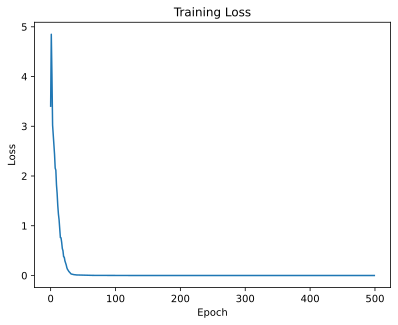

In [105]:
# 绘制损失曲线
plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# 测试网络

In [108]:
# 测试网络
correct = 0
total = 0
with torch.no_grad(): # 该局部关闭梯度计算功能
    Pred = model(X_test) # 一次前向传播
    _, Pred_classes = torch.max(Pred, dim=1)  # 找到最大概率对应的类别索引
    correct += torch.sum(Pred_classes == y_test)  # 计算正确的个数
    total = y_test.size(0)
    accuracy = correct.item() / total
    #print(f'Test accuracy: {accuracy:.2f} %')
    print(accuracy)

0.08008658008658008
